# 多类分类

一些算法（比如随机森林分类器或者朴素贝叶斯分类器） 可以直接处理多类分类问题。其他一些算法（比如 SVM 分类器或者线性分类器） 则是严格的二分类器。

使用one_vs_all策略或one_vs_one策略可以让二分类去执行多分类问题
- “一对所有”（OvA） 策略（也被叫做“一对其他”）：举个例子，创建一个可以将图片分成 10 类（从 0 到 9） 的系统的一个方法是：训练10个二分类器，每一个对应一个数字（探测器 0，探测器 1，探测器 2，以此类推） 。然后当你想对某张图片进行分类的时候，让每一个分类器对这个图片进行分类，选出决策分数最高的那个分类器。
- “一对一”（OvO）策略：对每一对数字都训练一个二分类器：一个分类器用来处理数字 0 和数字 1，一个用来处理数字 0 和数字 2，一个用来处理数字 1 和 2，以此类推。如果有 N 个类。你需要训练 N*(N-1)/2 个分类器。

Scikit-Learn 可以探测出你想使用一个二分类器去完成多分类的任务，它会自动地执行OvA（除了 SVM 分类器，它使用 OvO） 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST Original',data_home='../datasets/MNIST-data/')
X,y = mnist['data'],mnist['target']
X.shape,y.shape

D:\coding\Anaconda\envs\machine_learning\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
D:\coding\Anaconda\envs\machine_learning\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


((70000, 784), (70000,))

In [3]:
#切分训练集和测试集
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]
#打乱顺序
shuffle_index = np.random.permutation(60000)
X_train,y_train = X_train[shuffle_index],y_train[shuffle_index] 

In [4]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [5]:
some_digit = X[36000]
sgd_clf.predict([some_digit])

array([3.])

In [6]:
#可以看到sklearn训练了10个二分类器，有10个数值
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -8951.21355283, -23192.63616233,  -5595.61132124,
          1417.79646323, -23024.67461662,  -1152.99027567,
        -30565.39087472, -17576.06948986,  -8332.58824211,
        -19183.98703241]])

In [7]:
#找到最大值索引
np.argmax(some_digit_scores)

3

In [8]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [ ]:
#得到对应的标签
sgd_clf.classes_[5]

5.0

如果想选择使用 OvO 策略或者 OvA 策略，你可以使用 OneVsOneClassifier 类或者 OneVsRestClassifier 类

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)
ovo_clf.predict([some_digit])

array([5.])

In [ ]:
#N*(N-1)/2  10*9/2=45
len(ovo_clf.estimators_)

45

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train,y_train)
forest_clf.predict([some_digit])

D:\coding\Anaconda\envs\machine_learning\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5.])

这次 Scikit-Learn 没有必要去运行 OvO 或者 OvA，因为随机森林分类器能够直接将一个样例分到多个类别。你可以调用 predict_proba() ，得到样例对应的类别的概率值的列表

In [ ]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.88472306, 0.87644382, 0.8833325 ])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

D:\coding\Anaconda\envs\machine_learning\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90296941, 0.89519476, 0.90418563])

这里用的是归一化，不是书上说的正则化，为什么精度提高了还没搞清楚

## 误差分析

通过混淆矩阵可视化，观察误差生成的原因

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

D:\coding\Anaconda\envs\machine_learning\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5596,    0,   16,    7,   10,   45,   33,    5,  210,    1],
       [   1, 6428,   44,   20,    4,   38,    4,    8,  185,   10],
       [  27,   23, 5275,   86,   64,   25,   69,   36,  344,    9],
       [  23,   18,  109, 5241,    1,  207,   26,   46,  393,   67],
       [  12,   14,   41,   12, 5223,    9,   31,   21,  317,  162],
       [  25,   18,   32,  163,   54, 4472,   79,   15,  499,   64],
       [  31,   19,   52,    3,   42,   91, 5549,    5,  126,    0],
       [  20,   13,   56,   29,   49,   13,    5, 5708,  164,  208],
       [  17,   64,   44,   95,    3,  124,   33,    7, 5421,   43],
       [  21,   24,   30,   57,  125,   39,    1,  177,  341, 5134]],
      dtype=int64)

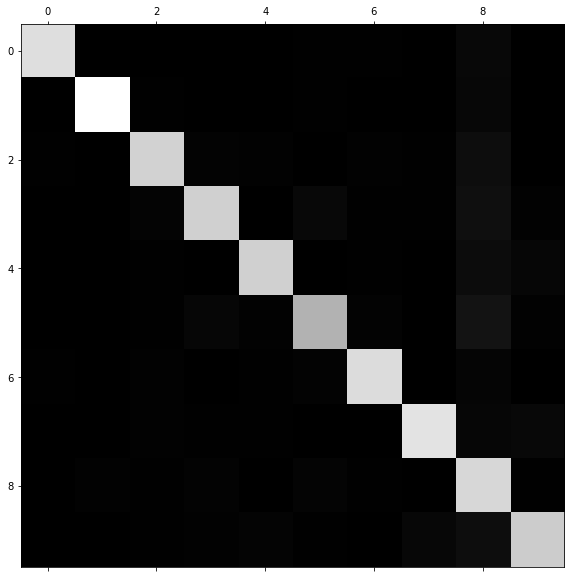

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

这个混淆矩阵看起来还不错，因为大多数的图片在主对角线上。在主对角线上意味着被分类正确。数字 5 对应的格子看起来比其他数字要暗淡许多。这可能是数据集当中数字 5 的图片比较少，又或者是分类器对于数字 5 的表现不如其他数字那么好。你可以验证两种情况

In [ ]:
#让混淆矩阵的每一个值除以相应类别的图片的总数目，得到比较错误率（对大类不公平）
row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx / row_sums

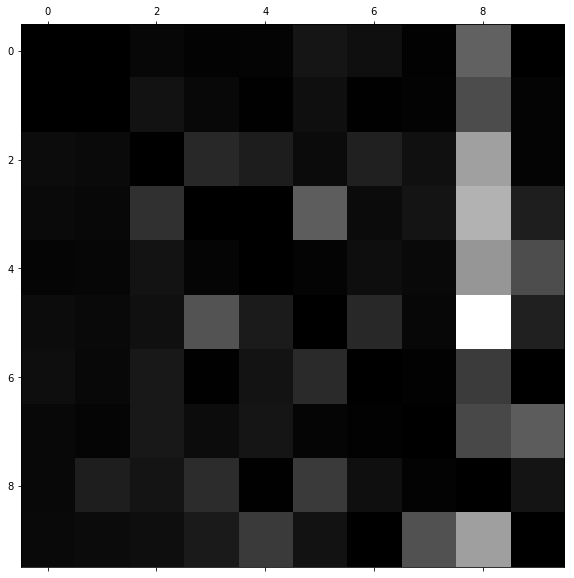

In [ ]:
#填充对角线为0，只保留被错误分类的数据
np.fill_diagonal(norm_conf_mx,0)
fig, ax = plt.subplots(figsize=(20,10))
ax.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

从图上可以清楚看到各类的误差，第 8、9 列相当亮，这告诉你许多图片被误分成数字 8 或者数字 9。  
图并不是严格对称的，比如比起将数字 8 误分类为数字 5 的数量，有更多的数字 5 被误分类为数字 8。  
通过这幅图，应该努力改善分类器在数字 8 和数字 9 上的表现，和纠正 3/5 的混淆

## 分析3和5的错误及纠正方法

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

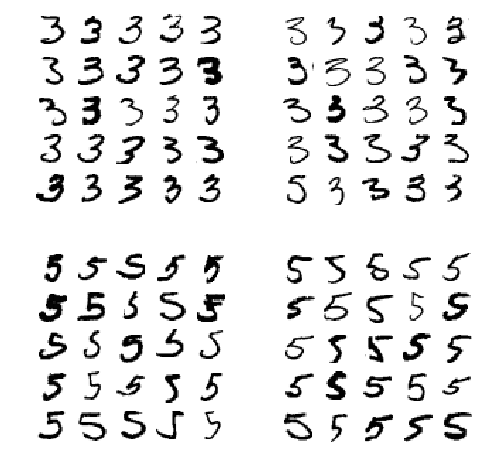

In [ ]:
cl_a, cl_b = 3, 5
#bool索引，只输出为True的数据
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

左边两个 5*5 的块将数字识别为 3，右边的将数字识别为 5。一些被分类器错误分类的数字
（比如左下角和右上角的块） 是书写地相当差，甚至让人类分类都会觉得很困难 。(比如第8行第三列的数字5，很像3)

但是，大部分被误分类的数字，在我们看来都是显而易见的错误。  
原因是我们使用的简单的 SGDClassifier ，这是一个线性模型。它所做的全部工作就是分配一个类权重给每一个像
素，然后当它看到一张新的图片，它就将加权的像素强度相加，每个类得到一个新的值。所
以，因为 3 和 5 只有一小部分的像素有差异，这个模型很容易混淆它们。

3 和 5 之间的主要差异是连接顶部的线和底部的线的细线的位置。如果你画一个 3，连接处稍
微向左偏移，分类器很可能将它分类成 5。反之亦然。换一个说法，这个分类器对于图片的位
移和旋转相当敏感。所以，减轻 3/5 混淆的一个方法是对图片进行预处理，确保它们都很好
地中心化和不过度旋转。这同样很可能帮助减轻其他类型的错误。

# 多标签分类

分类器给一个样例输出多个标签

下面一个简单的例子介绍多标签分类

In [ ]:
#创建2个标签大数字和奇数
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train > 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

In [ ]:
#它工作正确。数字 5 不是大数(False) ，同时是一个奇数(True)
knn_clf.predict([some_digit])

In [ ]:
#这里假设标签同等重要
from sklearn.metrics import f1_score
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_train,cv=3)
f1_score(y_train,y_train_knn_pred,average='macro')